# 7. Estudio sobre aerolíneas. 

En este capítulo se analizan las aerolíneas según los siguientes indicadores:

- volumen de los vuelos totales, 
- volumen de vuelos retrasado 
- volumen de vuelos cancelados

También se analizan las causas principales y más comunes detro de los vuelos retrasados. Dichas causas son las que aquí se incluyen:

- causas debidas al avión
- causas debidas al tiempo
- causas debidas a la seguridad
- causas debidas a sistemas de navegavión
- causas debidas al transportista

Por último, se analiza un parámetro que indica el **número de minutos de retraso acumulados** que además de los vuelos retrasados, da una idea de la importancia del tiempo de retraso de la aerolínea. 

## 7.1 Importación de librerías necesarias

Inicialmente se cargan las librerías de python necesarias.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

## 7.2 Conexión con MONGO ATLAS / LOCAL

In [2]:
#Mongo Atlas
#URI ="mongodb://sato:<PASSWORD>@satoclusterfaa-shard-00-00-gst6h.\
#azure.mongodb.net:27017,satoclusterfaa-shard-00-01-gst6h.azure.\
#mongodb.net:27017,satoclusterfaa-shard-00-02-gst6h.azure.mongodb\
#.net:27017/test?ssl=true&replicaSet=SatoClusterFAA-shard-0&authSource=admin&retryWrites=true"

#client = MongoClient(URI)
#db = client.FAA_Airlines

#local
client = MongoClient()#"mongodb://localhost:27017")
db = client.airports

Se crea la variable **air** para facilitar las consultas.

In [3]:
air = db.airlines

## 7.3 Evolución histórica de Ratios Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales por aerolínea. 

En este apartado se va a extraer la evolución histórica, dentro del período de estudio, de los **ratios de vuelos puntuales, retrasados y cancelados respecto a los vuelos totales por aerolínea**.

Para ello, se realiza la siguiente consulta en la que:

- se filtran los años de interés
- se agrupa por aerolínea, año y mes
- en dicha agrupación, se calcula la suma de:

    - vuelos retrasados
    - vuelos cancelados
    - vuelos puntuales

- se crean los campos:

    - ratios vuelos retrasados
    - vuelos vuelos cancelados
    - vuelos vuelos puntuales
    

Además, de la consulta, se va a **generar una colección "Histórico Aerolíneas"** para facilitar las consultas posteriores..

- **Query 20**

In [4]:
pipeline20 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": 
                        {"Aerolinea": "$carrier.code", "year": "$time.year", "month": "$time.month"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Puntuales": {"$sum": "$statistics.flights.on time"}
                        }
             },
             {"$project": {
                          "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                          "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                          "Ratio_Puntuales": {"$divide": ["$Puntuales", "$Totales"]}
                          }
             },
             {"$out": "Historico_Aerolineas"}
             
            ]

air.aggregate(pipeline20);

Se crea la variable **Aer** para facilitar las consultas. 

In [5]:
#Se almacena la colección en una variable
Aer = db.Historico_Aerolineas

Una vez obtenida la nueva colección, se procede a utilizarla.

## 7.4 Aerolíneas con peores Ratios de Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales. 

Partiendo de la colección creada, se plantéa la pregunta de cuáles son las **aerolíneas que peores Ratios medios han tenido**, durante los años de estudio.

Para esta pregunta se plantea la siguiente consulta.

- Se agupa por aerolínea
- Se calculan los **ratios medios** 

- **Query 21**

In [6]:
pipeline21 = [{"$group": {"_id": "$_id.Aerolinea", 
                          "Ratio_Retrasados": {"$avg": "$Ratio_Retrasados"},
                          "Ratio_Cancelados": {"$avg": "$Ratio_Cancelados"},
                          "Ratio_Puntuales": {"$avg": "$Ratio_Puntuales"}
                         }
              }
             ]

curs21 = Aer.aggregate(pipeline21)

El cursor obtenido se convierte en lista y se almacena en una lista y se convierte el resultado en un dataframe. Se ofrece una vista de los 10 primeros aeropuertos.

In [7]:
query21 = list(curs21)

In [8]:
df21 = pd.DataFrame(query21).set_index("_id").sort_index()
df21.index.name = "Aerolíneas"
df21.head(10)

,Ratio_Cancelados,Ratio_Puntuales,Ratio_Retrasados
Aerolíneas,,,
9E,0.03,0.79,0.18
AA,0.02,0.76,0.22
AQ,0.00,0.81,0.19
AS,0.01,0.82,0.17
B6,0.01,0.75,0.24
CO,0.01,0.76,0.22
DH,0.03,0.76,0.21
DL,0.01,0.80,0.19
EV,0.03,0.73,0.24


Se representa gŕaficamente los resultados anteriores.

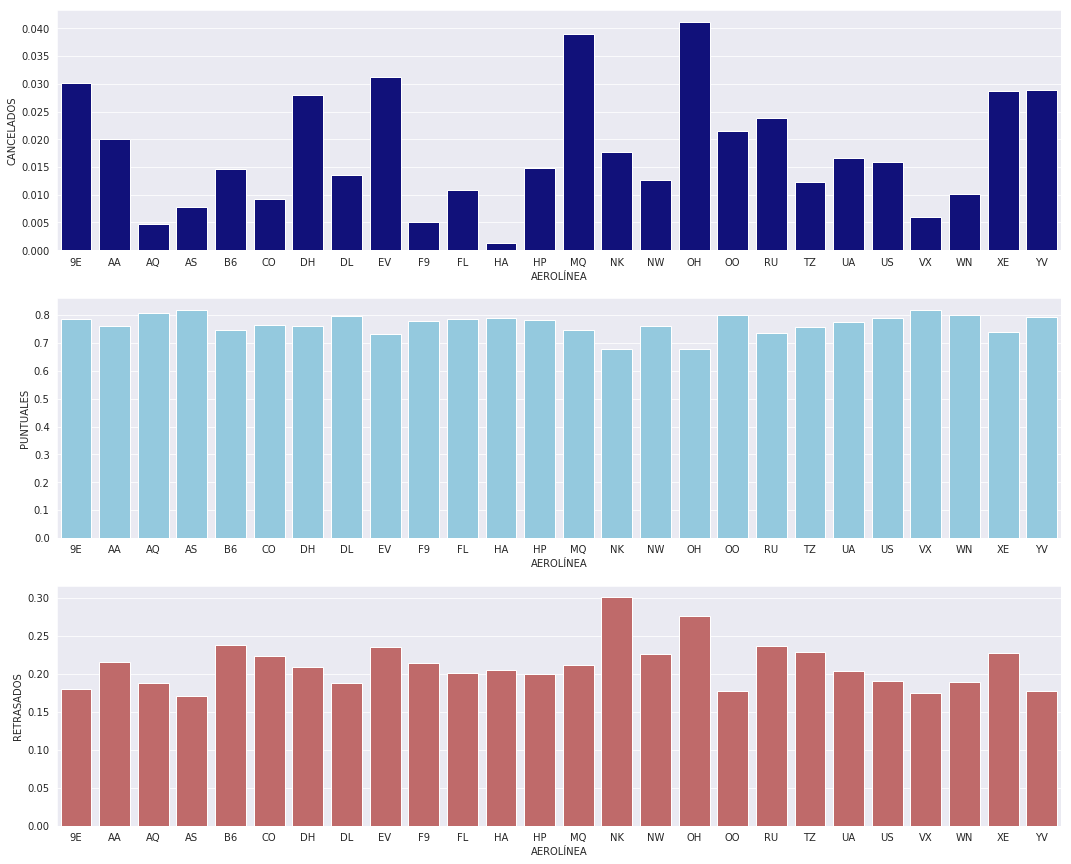

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15));

sns.barplot(x=df21.index, y= df21.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("CANCELADOS");
ax1.set_xlabel("AEROLÍNEA");

sns.barplot(x=df21.index, y= df21.iloc[:,1], color= 'SkyBlue', ax=ax2);
ax2.set_ylabel("PUNTUALES");
ax2.set_xlabel("AEROLÍNEA");

sns.barplot(x=df21.index, y= df21.iloc[:,2], color= 'IndianRed', ax=ax3);
ax3.set_ylabel("RETRASADOS");
ax3.set_xlabel("AEROLÍNEA");

En los gráficos anteriores se aprecian los siguientes resultados interesantes:

- Los aerolíneas con más **cancelaciones promedio son OH, MQ y EV**
- Los aerolíneas con más **retrasos promedio son NK, OH, B6, EV y RU**
- Los aerolíneas con **peor puntualidad son, como cabía esperar, NK y OH**

Por otro lado,

- Las aerolíneas con **mejor puntualidad son AS, AQ y VX**.

Para saber el **nombre de las aerolíneas anteriores**, la siguiente consulta nos da la correspondencia entre los códigos de las anteriores aerolíneas y sus respectivos nombres.

- **Query 22**

In [10]:
curs22 = air.find(
                 {"carrier.code": {"$in": ["OH", "MQ", "EV", "NK", "B6", "RU", "AS", "AQ", "VX"]}},
                 {"carrier.code": 1, "carrier.name": 1, "_id": 0}
)

In [11]:
query22 = list(curs22)

In [12]:
query22 = [(doc["carrier"]['code'], doc["carrier"]['name']) for doc in query22]
query22 = set(query22)

In [13]:
query22

{('AQ', 'Aloha Airlines Inc.'),
 ('AS', 'Alaska Airlines Inc.'),
 ('B6', 'JetBlue Airways'),
 ('EV', 'Atlantic Southeast Airlines'),
 ('EV', 'ExpressJet Airlines Inc.'),
 ('MQ', 'American Eagle Airlines Inc.'),
 ('MQ', 'Envoy Air'),
 ('NK', 'Spirit Air Lines'),
 ('OH', 'Comair Inc.'),
 ('RU', 'ExpressJet Airlines Inc.'),
 ('VX', 'Virgin America')}

## 7.5 Causas más comunes de retraso durante el período de estudio para las aerolíneas con mayores retrasos

Anteriormente se obtuvo que **las aerolíneas con más retrasos promedio son NK, OH, B6, EV y RU**. Si se quiere obtener **las principales causas** que, en promedio, han sido más frecuentes en el periodo de estudio, se ejecutaría la siguiente consulta:

- se filtran los años de interés
- se filtran las aerolíneas **NK, OH, B6, EV y RU**
- se crean los campos que tienen en cuenta el cociente entre los vuelos retrasados debidos a una causa y los vuelos totales retrasados:

    - Ratio_late aircraft: retrasos asociado al aeronave
    - Ratio_weather: retrasos asociado al tiempo
    - Ratio_security: retrasos asociado a la seguridad
    - Ratio_national aviation system. : retrasos asociado al sistema de navegación aérea
    - Ratio_carrier: retrasos asociado al transportista
    
- Se calculan los valores promedio

- **Query 23**

In [14]:
pipeline23 = [
    {"$match": {"time.year": {"$nin": [2003, 2016]},
                            "statistics.flights.delayed": {"$ne": 0}, #se quitan valores nulos
                            "carrier.code": {"$in": ["NK", "OH", "B6", "EV", "RU"]}}}, 
    {"$project": {
                "carrier.code": 1,    
                "Ratio_late aircraft": {"$divide": 
                            ["$statistics.# of delays.late aircraft", "$statistics.flights.delayed"]},
                "Ratio_weather": {"$divide": 
                            ["$statistics.# of delays.weather", "$statistics.flights.delayed"]},
                "Ratio_security": {"$divide": 
                            ["$statistics.# of delays.security", "$statistics.flights.delayed"]},
                "Ratio_national aviation system": {"$divide": 
                            ["$statistics.# of delays.national aviation system", 
                             "$statistics.flights.delayed"]},
                "Ratio_carrier": {"$divide": 
                            ["$statistics.# of delays.carrier", "$statistics.flights.delayed"]}}},
    {"$group": {"_id": "$carrier.code",
                "late": {"$avg": "$Ratio_late aircraft"},
                "weather": {"$avg": "$Ratio_weather"},
                "security": {"$avg": "$Ratio_security"},
                "system": {"$avg": "$Ratio_national aviation system"},
                "carrier": {"$avg": "$Ratio_carrier"}
                }
    }
]

curs23 = air.aggregate(pipeline23)

In [15]:
query23 = list(curs23)

In [16]:
df23 = pd.DataFrame(query23).set_index("_id").sort_index()
df23.index.name = "Aerolíneas"
df23

,carrier,late,security,system,weather
Aerolíneas,,,,,
B6,0.28,0.28,0.00,0.42,0.02
EV,0.36,0.27,0.01,0.32,0.06
NK,0.23,0.24,0.00,0.50,0.02
OH,0.38,0.04,0.00,0.43,0.15
RU,0.18,0.21,0.00,0.57,0.03


Si se representa gŕaficamente los resultados anteriores,

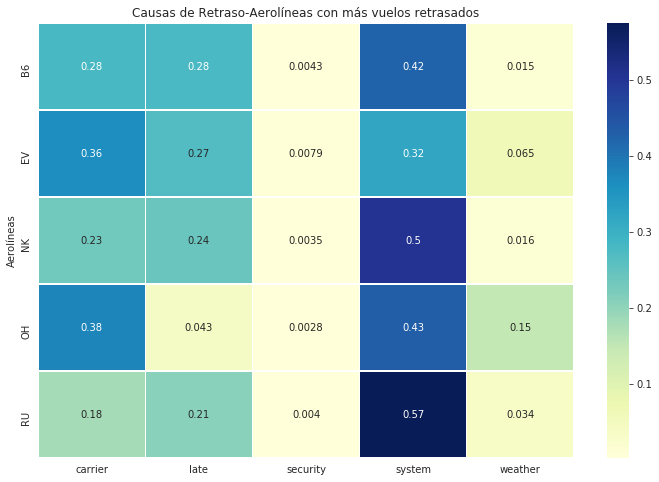

In [17]:
fig3, ax = plt.subplots(1, 1, figsize=(12,8));

ax = sns.heatmap(df23, annot=True, linewidths=.5, cmap="YlGnBu");
ax.set_title("Causas de Retraso-Aerolíneas con más vuelos retrasados");

Se observa que:

- las causas principales de retraso son en orden decreciente: 
    - las debidas a los sistemas de navegación aérea
    - y las debidas al transportista y al aeronave
- RU es la aerolínea con más retrasos debido a los sistemas de navegación aérea
- OH es la aerolínea con más retrasos debido a causas del transportista
- B6 es la aerolínea con más retrasos debido a causas del aeronave

## 7.6 Minutos de retraso promedio por aerolínea y causa del retraso

También es interesante estudiar **la varible minutos de retraso asociada a una determinada causa** que da una idea de la importancia de los tipos de retraso, en términos de tiempo, en el que los vuelos no operaron a la hora prevista por dichas causas.

Nos preguntamos **qué aerolíneas poseen, en promedio, mayores minutos de retraso para una causa determinada**. Para ello se diseña la siguiente consulta:

- se filtran los años de estudio
- se agrupa por códico de aerolínea
- se calculan los promedios de los minutos de retraso por causa de retraso

- **Query 24**

In [18]:
pipeline24 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$carrier.code",
                         "totales": {"$avg": "$statistics.minutes delayed.total"},
                         "late": {"$avg": "$statistics.minutes delayed.late aircraft"},
                         "weather": {"$avg": "$statistics.minutes delayed.weather"},
                         "carrier": {"$avg": "$statistics.minutes delayed.carrier"},
                         "security": {"$avg": "$statistics.minutes delayed.security"},
                         "system": {"$avg": "$statistics.minutes delayed.national aviation system"}
                        },
             },
              {"$sort": {"totales": -1}}
            ]

curs24 = air.aggregate(pipeline24);

In [19]:
query24 = list(curs24)

In [20]:
df24 = pd.DataFrame(query24).set_index("_id")
df24.index.name = "Aerolíneas"
df24.columns.name = "Minutos Retraso Promedio"
df24.head(10)

Minutos Retraso Promedio,carrier,late,security,system,totales,weather
Aerolíneas,,,,,,
WN,"5,252.72","11,913.96",57.01,"4,122.39","22,472.08","1,126.01"
AA,"5,046.01","6,246.92",21.68,"5,619.18","17,962.41","1,028.63"
EV,"4,629.71","6,054.06",10.77,"4,980.95","16,707.46","1,031.95"
MQ,"3,642.84","6,464.67",8.90,"5,091.33","16,060.93",853.18
OO,"3,679.65","6,437.29",30.55,"4,925.81","15,662.02",588.70
UA,"3,815.28","5,817.45",7.16,"4,661.15","14,739.24",438.20
DL,"4,421.29","4,059.22",11.54,"5,076.41","14,136.45",567.98
XE,"1,800.75","3,649.61",14.75,"5,628.19","11,464.99",371.69
DH,985.95,"5,462.13",9.22,"3,767.43","10,384.43",159.70


Representando lo anterior de forma gráfica

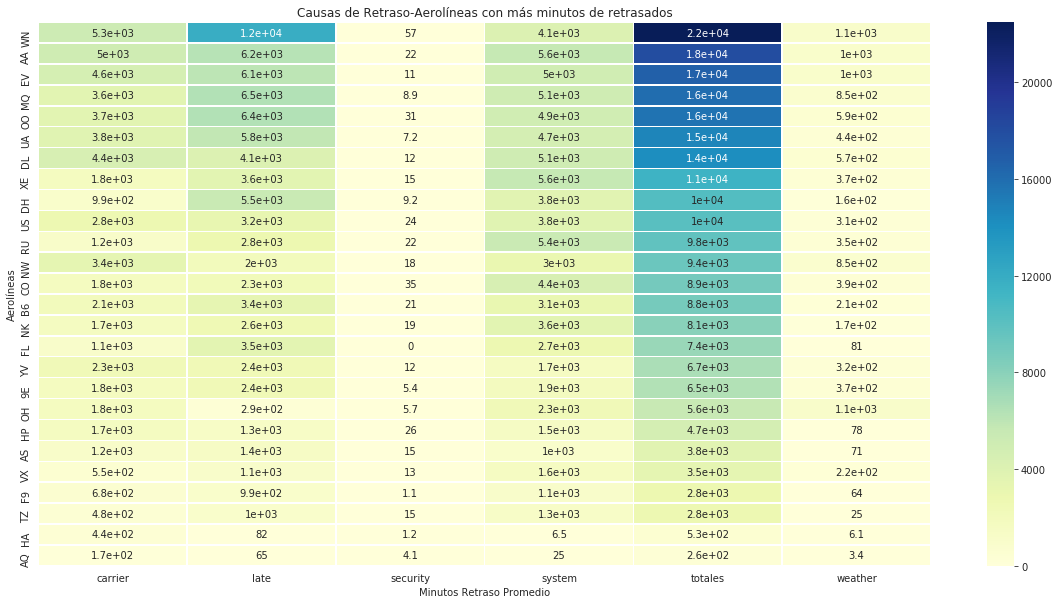

In [21]:
fig4, ax = plt.subplots(1, 1, figsize=(20, 10))

ax = sns.heatmap(df24, annot=True, linewidths=.5, cmap="YlGnBu");
ax.set_title("Causas de Retraso-Aerolíneas con más minutos de retrasados");

Se aprecia que dentro de las **cinco primeros aerolíneas (WN, AA, EV, MQ y OO) con más minutos promedio retrasados acumulados tan sólo EV está entre las tres primeras aerolíneas que más vuelos promedio retrasados tienen**. Para saber los nombres de estos tres:

- **Query 25**

In [22]:
curs25 = air.find(
                 {"carrier.code": {"$in":  ["WN", "AA", "EV", "MQ", "OO"]}},
                 {"carrier.code": 1, "carrier.name": 1, "_id": 0}
)

In [23]:
query25 = list(curs25)

In [24]:
query25 = [(doc["carrier"]['code'], doc["carrier"]['name']) for doc in query25]
query25 = set(query25)

Con esto, se obtienen los nombres de los aeropuertos

In [25]:
query25

{('AA', 'American Airlines Inc.'),
 ('EV', 'Atlantic Southeast Airlines'),
 ('EV', 'ExpressJet Airlines Inc.'),
 ('MQ', 'American Eagle Airlines Inc.'),
 ('MQ', 'Envoy Air'),
 ('OO', 'SkyWest Airlines Inc.'),
 ('WN', 'Southwest Airlines Co.')}

Nos podemos preguntar **si estas aerolíneas son los que mayor número de vuelos acumulados** han tenido durante el período de estudio.

- **Query 26**

In [26]:
pipeline26 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$carrier.code", 
                        "Totales": {"$sum": "$statistics.flights.total"}, 
                        }
             },
             {"$sort": {"Totales": -1}}    
            ]
curs26 = air.aggregate(pipeline26)

In [27]:
query26= list(curs26)

In [28]:
df26 = pd.DataFrame(query26).set_index("_id")
df26.index.name = "Aerolíneas"
df26.head(10)

,Totales
Aerolíneas,
WN,"6,686,567.00"
DL,"5,913,326.00"
AA,"5,684,755.00"
UA,"4,733,756.00"
US,"4,028,264.00"
OO,"3,810,012.00"
MQ,"3,071,868.00"
EV,"2,594,421.00"
CO,"1,812,000.00"


Representando gráficamente los resultados, no se confirma que las **aerolíneas con más minutos de retraso son los que mayor volumen de tráfico han tenido durante el período de estudio** excepto en al caso de AA.

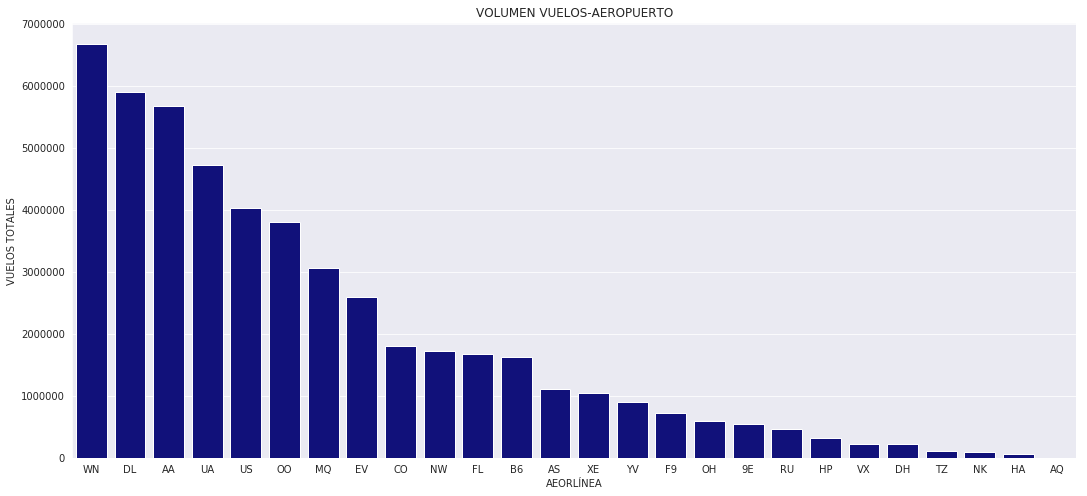

In [29]:
fig5, ax1 = plt.subplots(1, 1, figsize=(18,8));

sns.barplot(x=df26.index, y= df26.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("VUELOS TOTALES");
ax1.set_xlabel("AEORLÍNEA");
ax1.set_title("VOLUMEN VUELOS-AEROPUERTO");

## 7.7 Evolución anual de Minutos de retraso para las aerolíneas con código WN, AA, EV.

En este apartado, se analiza la **evolución anual en el período de estudio de los minutos de retraso acumulados en las aerolíneas con código WN, AA y EV**. Se diseña la siguiente consulta:

- se filtra los años de estudio
- se filtran las aerolíneas 
- se calculan los minutos de retraso

- **Query 27**

In [30]:
pipeline27 = [{"$match": {"time.year": {"$nin": [2003, 2016]},
                        "carrier.code": {"$in": ["WN", "AA", "EV"]}}
              },
              {"$group": {"_id": {"Aerolinea": "$carrier.code", "Year": "$time.year"},
                         "Totales": {"$sum": "$statistics.minutes delayed.total"}
                        }
             },
              {"$project": {"Aerolinea": "$_id.Aerolinea",
                            "Year": "$_id.Year",
                            "Totales": "$Totales",
                            "_id": 0
                           }
              },
              {"$sort": {"Year": 1}}
            ]

curs27 = air.aggregate(pipeline27);

In [31]:
query27 = list(curs27)

In [32]:
df27 = pd.DataFrame(query27).set_index(["Year", "Aerolinea"]).unstack()
df27

Totales                          
Aerolinea           AA           EV           WN
Year                                            
2,004.00  6,913,685.00 1,612,482.00 3,568,638.00
2,005.00  6,450,471.00 2,012,833.00 3,836,643.00
2,006.00  6,859,910.00 2,429,812.00 4,506,198.00
2,007.00  8,571,115.00 2,705,666.00 4,815,576.00
2,008.00  7,611,852.00 2,087,904.00 5,518,102.00
2,009.00  5,414,326.00 2,515,116.00 4,413,182.00
2,010.00  4,416,772.00 2,017,924.00 5,032,529.00
2,011.00  4,673,714.00 2,333,637.00 5,294,121.00
2,012.00  4,878,434.00 5,316,063.00 4,736,446.00
2,013.00  5,036,096.00 6,259,033.00 6,111,259.00
2,014.00  5,689,227.00 5,924,028.00 8,013,351.00
2,015.00  6,501,592.00 3,797,429.00 6,581,405.00

Representando la tabla anterior

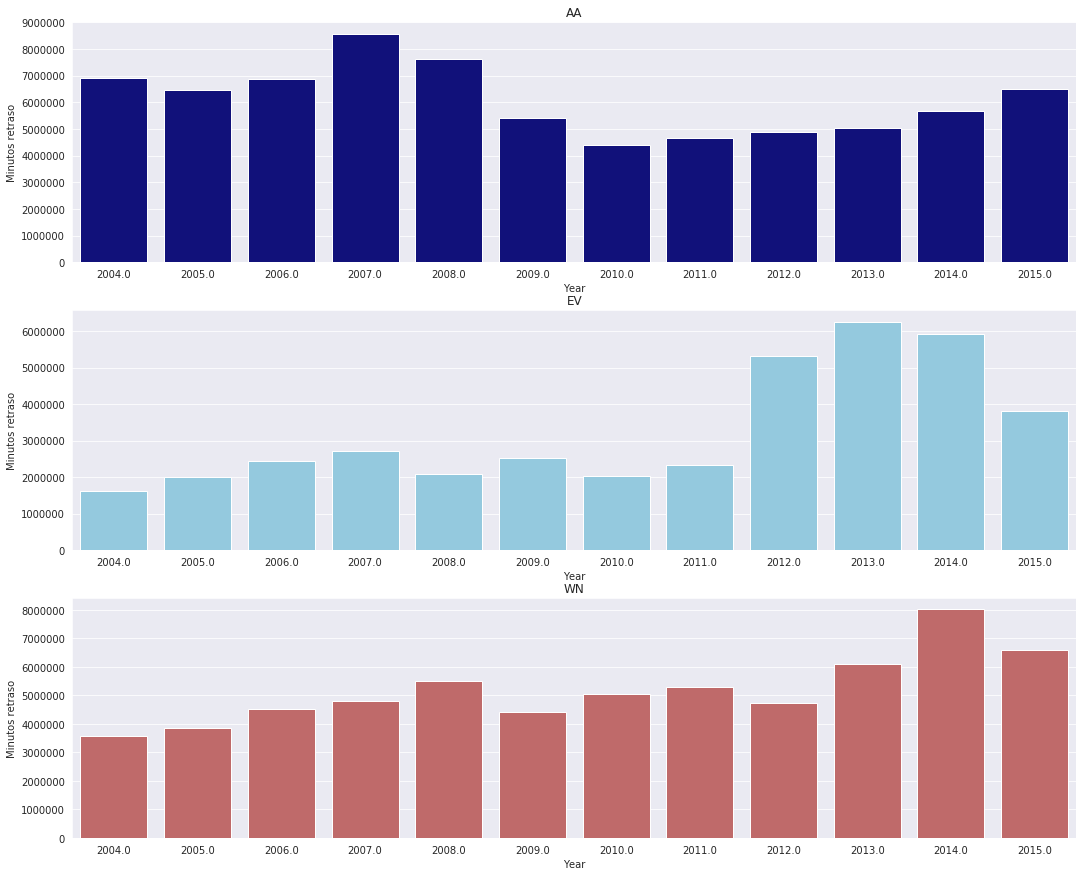

In [33]:
fig6, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15));

sns.barplot(x=df27.index, y= df27.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("Minutos retraso");
ax1.set_xlabel("Year");
ax1.set_title("AA");

sns.barplot(x=df27.index, y= df27.iloc[:,1], color= 'SkyBlue', ax=ax2);
ax2.set_ylabel("Minutos retraso");
ax2.set_xlabel("Year");
ax2.set_title("EV");

sns.barplot(x=df27.index, y= df27.iloc[:,2], color= 'IndianRed', ax=ax3);
ax3.set_ylabel("Minutos retraso");
ax3.set_xlabel("Year");
ax3.set_title("WN");

Se aprecia que:

- En la **aerolínea AA, después de un descenso en los años 2008, 2009 y 2010, se vuelve a un aumento en los minutos de retraso en años posteriores**
- En las **aerolíneas WN y EV parece que los minutos de retraso han crecido durante los años de estudio**.

## 7.8 Evolución mensual entre 2014-2015 de los Minutos de retraso, Ratio de vuelos cancelados, Ratio de vuelos retrasados y vuelos totales para los aerolíneas de WN, AA y EV.

En este apartado, se analiza la **evolución mensual de dichos indicadores durante los años 2014-2015 en las aerolíneas de WW, AA y EV**. Se diseña la siguiente consulta:

- se filtra los años de estudio
- se filtran las aerolíneas
- se calculan los indicadores 

- **Query 28**

In [34]:
pipeline28 = [{"$match": {"time.year": {"$in": [2014, 2015]},
                        "carrier.code": {"$in": ["WN", "AA", "EV"]}}
              },
              {"$group": {"_id": {"Aerolinea": "$carrier.code", 
                                  "Year": "$time.year",
                                  "Month": "$time.month"},
                         "minTotales": {"$sum": "$statistics.minutes delayed.total"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"}
                        }
             },
              {"$project": {"Aerolinea": "$_id.Aerolinea",
                            "Year": "$_id.Year",
                            "Month": "$_id.Month",
                            "minTotales": "$minTotales",
                            "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                            "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                            "Vuelos_Totales": "$Totales",
                            "_id": 0
                           }
              },
              {"$sort": {"Year": 1, "Month": 1}}
            ]

curs28 = air.aggregate(pipeline28);

In [35]:
query28 = list(curs28)

In [36]:
df28 = pd.DataFrame(query28).set_index(["Year", "Month", "Aerolinea"]).unstack()

Se crea el gráfico que nos da la **evolución de Vuelos Totales** en los tres aeropuertos seleccionados

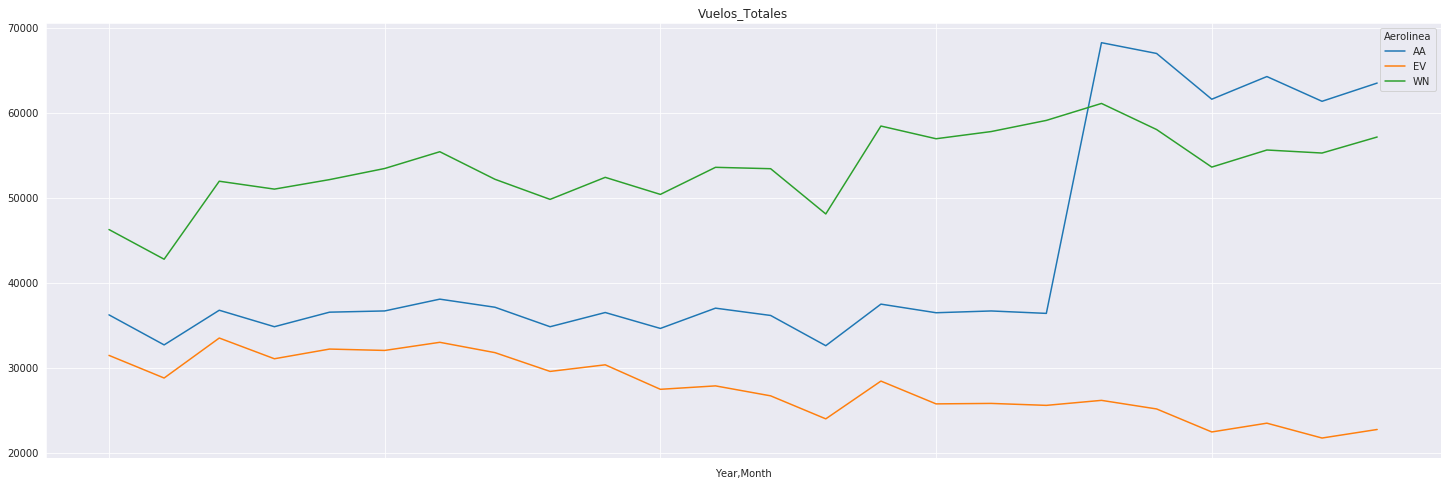

In [37]:
df28["Vuelos_Totales"].plot(kind= "line", figsize=(25,8), title = "Vuelos_Totales");

Se aprecia que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015:

- En **WN crece el número de vuelos**
- En **EV desciende el número de vuelos**
- En **AA se produce un gran aumento en el número de vuelos durante el último semestre de 2015**
    

Para los **Ratios de los Vuelos Retrasados**

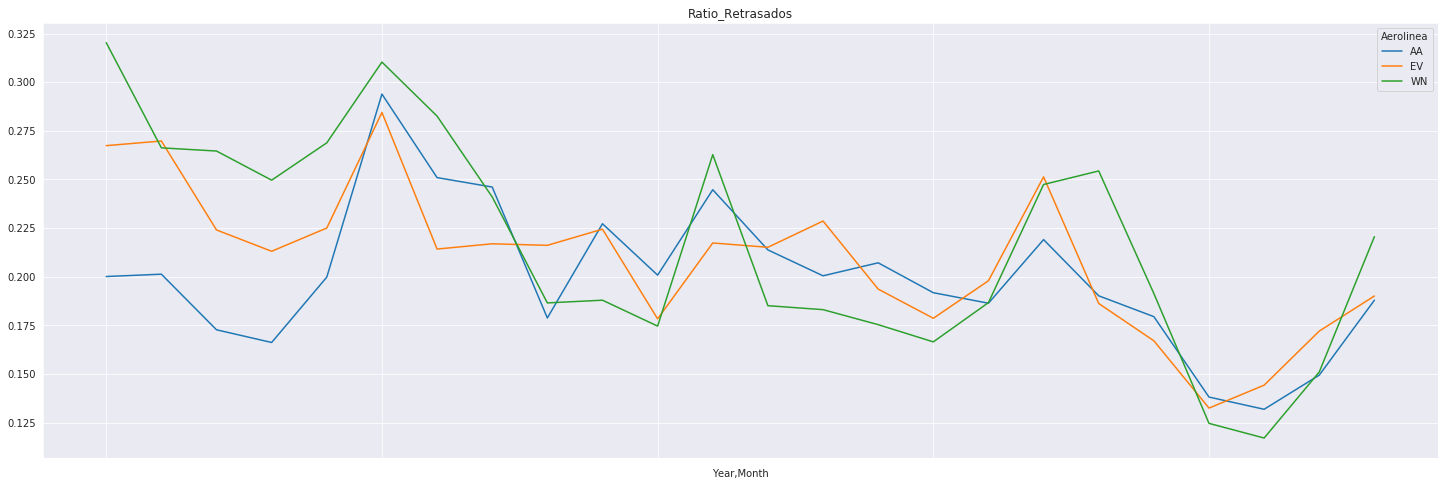

In [38]:
df28["Ratio_Retrasados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Retrasados");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::

- En las **tres aerolíneas el Ratio de retrasados disminuye**.
    

Para los **Ratios de los Vuelos Retrasados**

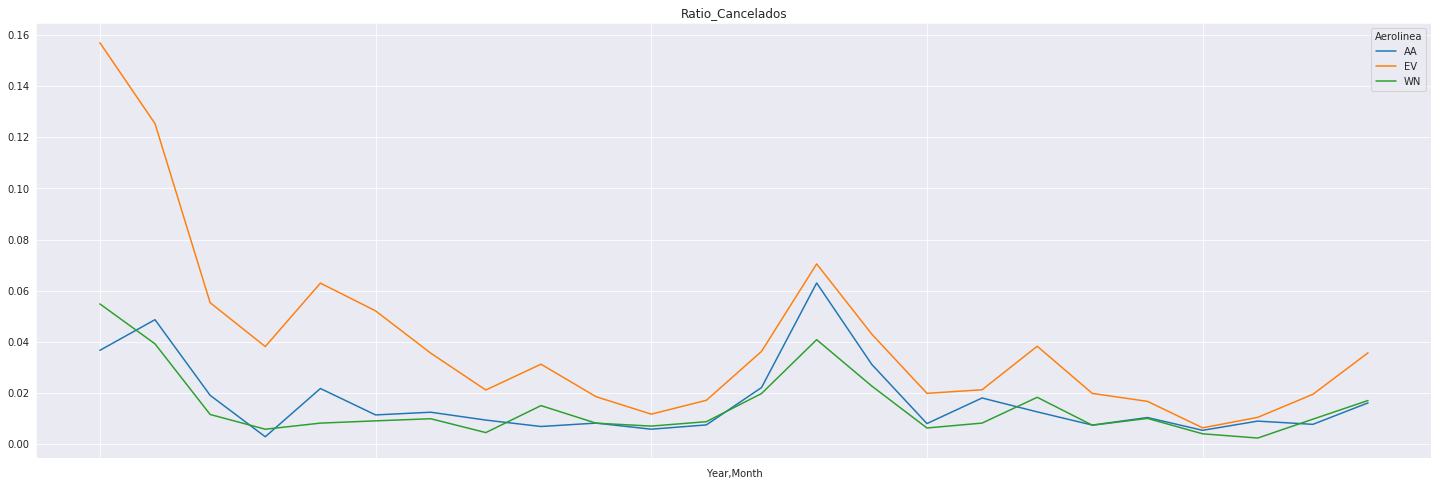

In [39]:
df28["Ratio_Cancelados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Cancelados");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::
    
- En las **tres aerolímeas el Ratio de Cancelaciones permanece estable**.   

Para los **Minutos de retraso totales**

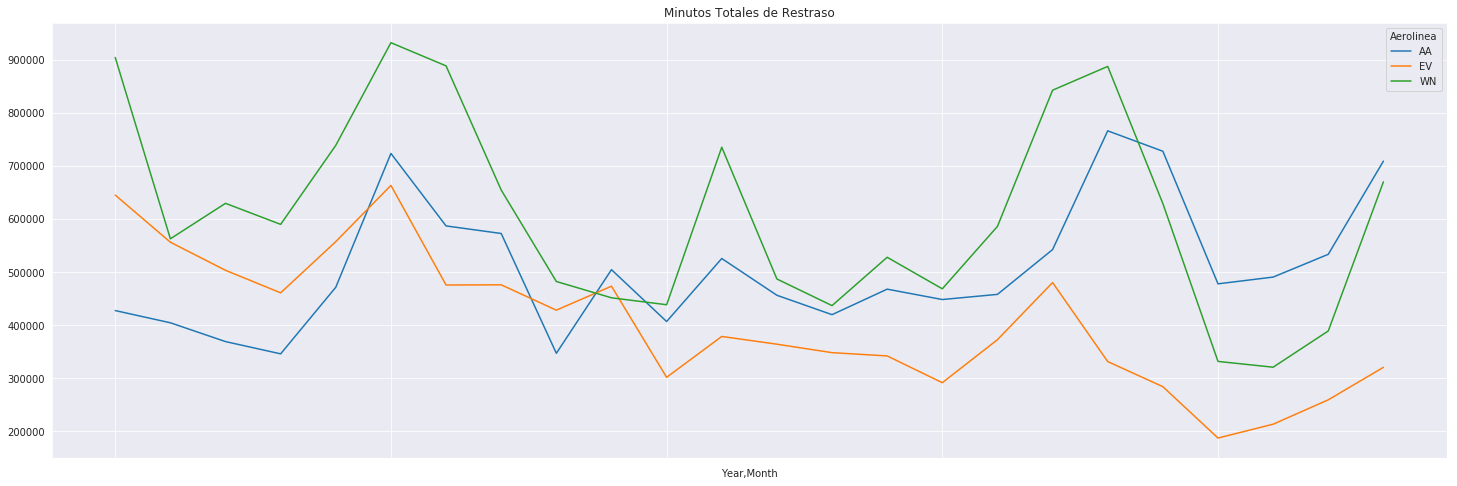

In [40]:
df28["minTotales"].plot(kind= "line", figsize=(25,8), title = "Minutos Totales de Restraso");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::
    
- En las **tres aerolíneas los minutos de retraso totales disminuyen ligeramente**.  